In [1]:
import os
from rosemary import jpt_setup; jpt_setup()

import matplotlib.pyplot as plt


from transformers.trainer_utils import get_last_checkpoint

import re
from llm.submit import (
    multiline_to_singleline,
    submit_job_ccc,
    submit_job_aimos,
    submit_job,
        get_run_statistics)
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import json
import tempfile
import subprocess
import shlex
import datetime
import itertools
import glob

import base64
string_to_alphanumeric = lambda s: base64.urlsafe_b64encode(s.encode('utf-8')).decode('utf-8')
alphanumeric_to_string = lambda a: base64.urlsafe_b64decode(a).decode('utf-8')

from llm.submit import shell_scripts_template_slurm, shell_scripts_template_lsf, get_host_info

info = get_host_info()
arch, cluster = info['arch'], info['cluster']
print(info)

## jobs submitted in notebook inherits env variables.
cache_dir = '/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/cache'
os.environ['WANDB_DIR'] = cache_dir
os.makedirs(os.environ['WANDB_DIR'], exist_ok=True)
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_PROJECT'] = 'mitibm'
##
##

shell_scripts_template = shell_scripts_template_slurm \
    if arch == 'ppc64le' else shell_scripts_template_lsf

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


{'arch': 'ppc64le', 'cluster': 'dcs'}


# Finetuning with openinstruct/finetune.py


In [2]:
# job_name = 'ft'
# test_run = 1
# test_run = bool(test_run)

# queue = 'x86_12h' # 'x86_12h'
# num_cpus = 20
# num_gpus = 1
# cpu_mem = 32
# require = 'a100_80gb'

# # model_name_or_path = 'mosaicml/mpt-7b'; max_seq_length = 2048
# # model_name_or_path = 'gpt2'; max_seq_length = 1024
# # model_name_or_path = 'gpt2-Large'; max_seq_length = 1024
# # model_name_or_path = 'gpt2-xl'; max_seq_length = 1024
# model_name_or_path = 'huggyllama/llama-7b'; max_seq_length = 2048


# train_file = 'data/processed/oasst1/oasst1_data.jsonl'; train_file_short = 'oasst1'
# train_file = 'data/processed/flanv2_cot_oasst1_dolly.jsonl'; train_file_short = 'human_mix'
# # train_file = 'data/processed/flanv2_cot_oasst1_dolly_shuffled.jsonl'; train_file_short = 'human_mix_shuffled'

# output_dir = f"results/{model_name_or_path.replace('/', ':')}_{train_file_short}"
# if test_run:
#     output_dir = 'jpt_' + output_dir

# use_deepspeed = False
# # deepspeed_config_file = 'ds_configs/stage3_no_offloading_accelerate_setauto.conf'
# # deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate.conf'
# deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate_setauto.conf'

# use_lora = True
# lora_rank = 4
# lora_alpha = lora_rank
# lora_dropout = 0.05

# batch_size_per_gpu = 1
# total_batch_size = 128
# mixed_precision = 'bf16' # 'bf16', 'fp16'
# checkpointing_steps = None # every n steps, where n='1' or every 'epoch'

# gradient_acc_steps = int(total_batch_size/num_gpus/batch_size_per_gpu)

# print(f"Training {model_name_or_path} "
#       f"using {num_gpus} GPUs, "
#       f"{batch_size_per_gpu} batch size per GPU, "
#       f"{gradient_acc_steps} gradient accumulation steps.")

# # do use fast tokenizer since mpt-7b does not have a fast tokenizer counter-part
# #     --use_slow_tokenizer \
# # do not use flash attention, since having problem installing flash-attn with cuda 12.1
# #     --use_flash_attn \

# cmd = f"""
# {'!cd .. && ' if test_run else ''}accelerate launch \
#     --mixed_precision {mixed_precision} \
#     --num_machines 1 \
#     --num_processes {num_gpus} \
#     {'--use_deepspeed' if use_deepspeed else ''}
#     {'--deepspeed_config_file '+deepspeed_config_file if use_deepspeed else ''}
#     open_instruct/finetune.py \
#     --model_name_or_path {model_name_or_path} \
#     --tokenizer_name {model_name_or_path} \
#     --train_file {train_file} \
#     --max_seq_length {max_seq_length} \
#     {'--use_lora' if use_lora else ''}
#     --lora_rank {lora_rank} \
#     --lora_alpha {lora_alpha} \
#     --lora_dropout {lora_dropout} \
#     --preprocessing_num_workers 16 \
#     --per_device_train_batch_size {batch_size_per_gpu} \
#     --gradient_accumulation_steps {gradient_acc_steps} \
#     --learning_rate 2e-5 \
#     --lr_scheduler_type linear \
#     --warmup_ratio 0.03 \
#     --weight_decay 0. \
#     --num_train_epochs 2 \
#     --output_dir {output_dir} \
#     --with_tracking \
#     --report_to tensorboard \
#     {'--checkpointing_steps '+str(checkpointing_steps) if checkpointing_steps else ''}
#     --logging_steps 1
# """

# # things to test to see its effects on (1) eval perf (2) runtime.
# #
# # - int8
# # - mixed_precision bf16 or no
# # - with/without LoRA
# # - LoRA's rank/alpha (alpha typically set to 2*rank)
# # - batch size
# # - micro-batch size (largest without running out of memory)


# cmd = multiline_to_singleline(cmd)
# if test_run:
#     print()
#     print(cmd)


# shell_scripts = shell_scripts_template.format(
#     conda_env='open-instruct',
#     cwd=os.path.dirname(os.getcwd()),
#     cmd=cmd,
#     log_dir=os.getcwd(),
#     save_dir=output_dir
# )
# out = submit_job_ccc(
#     shell_scripts, 
#     job_name=job_name, 
#     queue=queue,
#     num_cpus=num_cpus,
#     cpu_mem=cpu_mem,
#     require=require,
#     num_gpus=num_gpus,
#     test_run=test_run,
# )
# if not test_run:
#     print(out)

# Finetuning with openinstruct/finetune_trainer.py


In [ ]:
t = '00:33:12'
n = 15
# total = 1515; nnodes = 1
# total = 2083; nnodes = 1
total = 1587; nnodes = 1
# total = 1041; nnodes = 1
# total = 4228; nnodes = 1
# total = 4512; nnodes = 4
# total = 4296; nnodes = 1
# total = 2254; nnodes = 2
# total = 1128; nnodes = 4
# total = 1074; nnodes = 4
# total = 1252; nnodes = 4

l = [int(x) for x in t.split(':')]
t = l[0]*60*60+l[1]*60+l[2]
# t = t/60/60 # in hr

print(f'{t/n/nnodes:.0f}s/it, {t/n*total/60/60:.1f}hrs')

In [ ]:


# how to sample mixture sample size?
# 
# approaches: 
# (1) want sufficient coverage for #datapoints/dataset, #datasets used, total sample size.
#  Use 5k as a unit of data, sample different #unit/dataset, and vary total units of data.
# (2) specify a total sample size and a mixture weight. this answers the question, given a 
#  fixed compute budget, what is the optimal mixture. this seems to be a simpler approach.
#
# experiments
# (1) first use samples from a single dataset for tuning. 
# (2)
# 


datasets = ['baize', 'code_alpaca', 'cot', 'dolly', 'flan_v2', 'gpt4_alpaca', 'oasst1', 'self_instruct', 'sharegpt', 'stanford_alpaca', 'super_ni', 'unnatural_instructions']
total_data_points = 200000

subsample_mixture_list = []
subsample_mixture_list += [
    {k: 100000} for k in datasets if k != 'flan_v2'
]
subsample_mixture_list += [
    {k: int(total_data_points/4) for k in ['cot', 'flan_v2', 'dolly', 'oasst1']}
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items())
]
subsample_mixture_list += [
    {k: int(total_data_points/len(datasets)) for k in datasets} 
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': .07678, 'flan_v2': .9137, 'dolly': .004471, 'oasst1': .009072}.items())
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.1127, 'flan_v2': 0.8726, 'dolly': 0.01395, 'oasst1': 0.001391}.items())
]
subsample_mixture_list

In [ ]:
## Clean up checkpoints `optimizer.bin` to save disk space. 
# (e.g., 7b model, ~8*7=56GB for storing gradient/momentum in `optimizer.bin`)

import glob, os

def cleanup_checkpoints(save_dir, test_run=False):

    checkpoints = glob.glob(os.path.join(save_dir, 'checkpoint-*'))
    checkpoints = sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))
    checkpoints = checkpoints[:-1]
    
    if not checkpoints: return

    for ckpt_path in checkpoints:
        optimizer_bin_path = os.path.join(ckpt_path, 'optimizer.bin')
        if os.path.isfile(optimizer_bin_path):
            print(optimizer_bin_path)
            if not test_run:
                os.remove(optimizer_bin_path)
        
        
test_run = 1
test_run = bool(test_run)
exp_dirs = [
    '../results/ft1',
    '../results/ft2',
    '../results/oi3',
    '../results/oi4',
    '../results/oi4_perf_cross_time',
    '../results/oi4_tulu_v1_human_mix',
    '../results/oi4_flanv2_prune_with_hmv1_model',
    '../results/oi4_flan_v2_vary_subsetsize',
]

print('Remove extra files (e.g., optimizer.bin) for non-latest checkpoints:')

for exp_dir in exp_dirs:
    for run_name in os.listdir(exp_dir):
        save_dir = os.path.join(exp_dir, run_name)
        if os.path.islink(save_dir): continue
        cleanup_checkpoints(save_dir, test_run=test_run)

In [41]:
def compute_mixture_num_samples(mixture, max_train_samples):
    s = sum(mixture.values())
    mixture = {k: int(max_train_samples*v/s) for k, v in mixture.items()}
    return mixture

add_hardwarespec_to_dirname = False
num_cpus = 144 if arch == 'ppc64le' else 32
cpu_mem =  512 if arch == 'ppc64le' else 64


save_strategy = 'steps'
save_steps = 100
save_total_limit = 1
preprocessing_num_workers = 32
evaluation_strategy = 'no' # set do_eval=False
eval_steps = save_steps


dataloader_sampler = None
hf_models_dir = 'results/baselines/'
# model_name_or_path = 'results/baselines/gpt2-medium'; abbr_model_name = 'gpt2m'; max_seq_length = 1024
model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# model_name_or_path = 'results/baselines/NousResearch/Llama-2-7b-hf'; abbr_model_name = 'llama2-7b'; max_seq_length = 2048
# model_name_or_path = 'mosaicml/mpt-7b'; abbr_model_name = 'mpt-7b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-1.4b'; abbr_model_name = 'pythia-1.4b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-2.8b'; abbr_model_name = 'pythia-2.8b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-6.9b'; abbr_model_name = 'pythia-6.9b'; max_seq_length = 2048



subsample_mixture_list = []
# subsample_mixture_list += [
#     {k: max_train_samples} for k in datasets
# ]
# subsample_mixture_list += [
#     {k: int(max_train_samples/4) for k in ['cot', 'flan_v2', 'dolly', 'oasst1']}
# ]
# subsample_mixture_list += [
#     ('humanmix', dict((k, int(v*max_train_samples)) for k, v in
#     {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items()))
# ] # humanmix mixture.
# subsample_mixture_list += [
#     {k: int(max_train_samples/len(datasets)) for k in datasets} 
# ]
# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {'cot': .07678, 'flan_v2': .9137, 'dolly': .004471, 'oasst1': .009072}.items())
# ]
# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {'cot': 0.1127, 'flan_v2': 0.8726, 'dolly': 0.01395, 'oasst1': 0.001391}.items())
# ]
# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {'cot':  0.13568177819252014, 'flan_v2': 0.3957784175872803, 
#      'dolly': 0.05964866653084755, 'oasst1': 0.4088916480541229}.items())
# ] # gpt2-medium_humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.360595703125, "dolly": 0.0021991729736328125, "flan_v2": 0.63037109375, "oasst1": 0.0016956329345703125}.items())
# ] # pythia-1.4b humanmix_uniform:200k_doremiv1.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.2254638671875, "dolly": 0.01409149169921875, "flan_v2": 0.1739501953125, "oasst1": 0.59423828125}.items())
# ] # pythia-1.4b humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.08563232421875, "dolly": 0.54296875, "flan_v2": 0.347900390625, "oasst1": 0.0103302001953125}.items())
# ] # llama-7b_humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.0316162109375, "dolly": 0.204833984375, "flan_v2": 0.40966796875, "oasst1": 0.40966796875}.items()
#         )] # llama-7b_humanmix_uniform:600k_doremiv2.json

# subsample_mixture_normalized_list = []
# subsample_mixture_normalized_list += [('uniform:1200k_doremiv2', # llama-7b_humanmix_uniform:1200k_doremiv2.json
#                                        {"cot": 0.11419677734375, "dolly": 0.1024169921875, "flan_v2": 0.204833984375, "oasst1": 0.204833984375})]
## 10 for trying out datamodels
# mixes = [{'cot': 0.37664033529374275,
#   'dolly': 0.0874640765523398,
#   'flan_v2': 0.39740799933549775,
#   'oasst1': 0.1384875888184196},
#  {'cot': 0.23064419241874784,
#   'dolly': 0.04693354147889885,
#   'flan_v2': 0.72121745986295,
#   'oasst1': 0.0012048062394032465},
#  {'cot': 0.11244721555034376,
#   'dolly': 0.21997027355988638,
#   'flan_v2': 0.5826671754210359,
#   'oasst1': 0.08491533546873392},
#  {'cot': 0.27704626812045546,
#   'dolly': 0.5712282144637615,
#   'flan_v2': 0.024940119654536592,
#   'oasst1': 0.12678539776124645},
#  {'cot': 0.0024519793352964607,
#   'dolly': 0.13274603201304974,
#   'flan_v2': 0.012268378167304219,
#   'oasst1': 0.8525336104843496},
#  {'cot': 0.08065633865016615,
#   'dolly': 0.41886215168938545,
#   'flan_v2': 0.21723932820070485,
#   'oasst1': 0.2832421814597436},
#  {'cot': 0.13878643021160036,
#   'dolly': 0.05686171157146557,
#   'flan_v2': 0.6701353469446995,
#   'oasst1': 0.13421651127223455},
#  {'cot': 0.2461125374866837,
#   'dolly': 0.09774240280444893,
#   'flan_v2': 0.13974091986040005,
#   'oasst1': 0.5164041398484672},
#  {'cot': 0.4069781049152398,
#   'dolly': 0.06318759506033228,
#   'flan_v2': 0.09504719644992135,
#   'oasst1': 0.4347871035745066},
#  {'cot': 0.22379693013848484,
#   'dolly': 0.30565901275011814,
#   'flan_v2': 0.15457716965000887,
#   'oasst1': 0.31596688746138824}]

# mixes = [
#     {'cot': 0.46638974, 'dolly': 0.01456044, 'flan_v2': 0.50886009, 'oasst1': 0.01018973},
#     {'cot': 0.39744481, 'dolly': 0.00472114, 'flan_v2': 0.59104177, 'oasst1': 0.00679229},
# ]

# subsample_mixture_normalized_list += [('', d) for d in mixes]
# subsample_mixture_normalized_list += [('humanmix', # humanmix
#                                        {'cot': 0.48785105, 'dolly': 0.00732313, 'flan_v2': 0.48785105, 'oasst1': 0.01697478})]
# subsample_mixture_normalized_list = [(x[0],  compute_mixture_num_samples(x[1], max_train_samples)) 
#                                      for x in subsample_mixture_normalized_list]
# subsample_mixture_list += subsample_mixture_normalized_list


subsample_mixture_list = [('',None)]
subsample_inds_file_list = [None]


train_file = 'data/processed/all.jsonl'; abbr_train_file = 'all'



max_train_samples_list = [None]
num_train_epochs_list = [1]




def subsample_inds_file_abbr_fn(x):
    s = os.path.basename(x).split('.pkl')[0]
    if s.startswith('inds_'):
        scoring_fn = os.path.basename(os.path.dirname(x)).replace('_', ':')
        pacing_fn = s.split('inds_')[-1].replace('_', ':')
        return f'score={scoring_fn}_pace={pacing_fn}'
    else:
        return s

# ##  ft1: reproduce open-instruct table with llama7b
# # job_name = 'ft1'; num_train_epochs_list = [2]
# # job_name = 'ft1_ep=1'; num_train_epochs_list = [1] # train for 1 epoch (baseline for comparison.)
# # job_name = 'ft1_ep=2'; num_train_epochs_list = [2]
# job_name = 'oi2'; num_train_epochs_list = [2] # 5, 10
# model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# train_file = 'data/processed/wizardlm/wizardlm_data.jsonl'; abbr_train_file = 'wizardlm'

# train_file = 'data/processed/lima/lima_data.jsonl'; abbr_train_file = 'lima'
# train_file = 'data/processed/cot/cot_data.jsonl'; abbr_train_file = 'cot'
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
# # # train_file = 'data/processed/wpq/cot_flanv2_data.jsonl'; abbr_train_file = 'cot:flanv2'
# # # train_file = 'data/processed/tulu/tulu_v1_human_mix.jsonl'; abbr_train_file = 'hmv1'
# train_file = 'data/processed/tulu/tulu_v1_mix.jsonl'; abbr_train_file = 'tuluv1m'
# train_file = 'data/processed/sharegpt/sharegpt_data.jsonl'; abbr_train_file = 'sharegpt'



# model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048
# train_file = 'data/processed/ultrachat/ultrachat200k_train_data.jsonl'; abbr_train_file = 'ultrachat200k'
# train_file = 'data/processed/lima/lima_data.jsonl'; abbr_train_file = 'lima'

# # max_train_samples_list = [120]; save_steps = 1; save_total_limit = 100



# # train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly'
# # train_file = 'data/processed/oasst1/oasst1_data.jsonl'; abbr_train_file = 'oasst1'
# # train_file = 'data/processed/super_ni/super_ni_data.jsonl'; abbr_train_file = 'super_ni'
# # train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca'
# # train_file = 'data/processed/baize/baize_data.jsonl'; abbr_train_file = 'baize'
# # train_file = 'data/processed/self_instruct/self_instruct_data.jsonl'; abbr_train_file = 'self_instruct'
# # train_file = 'data/processed/code_alpaca/code_alpaca_data.jsonl'; abbr_train_file = 'code_alpaca'
# # train_file = 'data/processed/unnatural_instructions/unnatural_instructions_data.jsonl'; abbr_train_file = 'unnatural_instructions'
# # train_file = 'data/processed/gpt4_alpaca/gpt4_alpaca_data.jsonl'; abbr_train_file = 'gpt4_alpaca'


# # ft2: test mixture weights
# # vary mixture weights
# job_name = 'ft2'

# # oi3: instruction tuning performance w.r.t. steps.
# job_name = 'oi3'

# # oi4: data pruning 
# job_name = 'oi4_flan_v2_vary_subsetsize'
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
# subsample_mixture_list = [('',None)]
# max_train_samples_list = [int(pct*100000) for pct in [.1, .3, .5]]; num_train_epochs_list = [2]
# data_inds_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/flan_v2/'
# subsample_inds_file_list = [
# #     os.path.join(data_inds_dir, 'random.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'prob_decr.pkl'),
# #     os.path.join(data_inds_dir, 'prob_incr.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_k=Kcos.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_k=Kcosp.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_k=Kcos1np.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_incr.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_decr.pkl'),
#     os.path.join(data_inds_dir, 'kmeanscd_nc=3000_incr.pkl'),
#     os.path.join(data_inds_dir, 'kmeanscd_nc=3000_decr.pkl'),
# ]


# # oi4_perf_cross_time: perf cross time on flan_v2
# job_name = 'oi4_perf_cross_time'
# save_steps = 50; save_total_limit = 200
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
# subsample_mixture_list = [('',None)]
# max_train_samples_list = [int(pct*100000) for pct in [.3]]; num_train_epochs_list = [3]
# data_inds_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/flan_v2/'
# subsample_inds_file_list = [
#     os.path.join(data_inds_dir, 'random.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=300_decr.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=300_incr.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=1000_decr.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=1000_incr.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_decr.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_incr.pkl'),
#     os.path.join(data_inds_dir, 'prob_decr.pkl'),
#     os.path.join(data_inds_dir, 'prob_incr.pkl'),
#     os.path.join(data_inds_dir, 'dppmap_k=Kcos.pkl'),
#     os.path.join(data_inds_dir, 'dppmap_k=Kcosp.pkl'),
#     os.path.join(data_inds_dir, 'dppmap_k=Kcos1np.pkl'),
#     os.path.join(data_inds_dir, 'el2n_incr.pkl'),
#     os.path.join(data_inds_dir, 'el2n_decr.pkl'),
# ]

# # ## oi4_flanv2_prune_with_hmv1_model
# job_name = 'oi4_flanv2_prune_with_hmv1_model'
# save_steps = 50; save_total_limit = 200
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
# subsample_mixture_list = [('',None)]
# max_train_samples_list = [int(pct*100000) for pct in [.3]]; num_train_epochs_list = [3]
# data_inds_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b_ft=hmv1/flan_v2/'
# subsample_inds_file_list = [
# #     os.path.join(data_inds_dir, 'random.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_incr.pkl'),
#     os.path.join(data_inds_dir, 'prob_incr.pkl'),
# #     os.path.join(data_inds_dir, 'prob_decr.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_k=Kcos.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_k=Kcosp.pkl'),
#     os.path.join(data_inds_dir, 'el2n_incr.pkl'),
#     os.path.join(data_inds_dir, 'el2n_decr.pkl'),
# ]

# ## tulu mix v1.
# dataset = 'tulu_v1_human_mix'; train_file = 'data/processed/tulu/tulu_v1_human_mix.jsonl'; abbr_train_file = 'tuluv1hm'
# job_name = f'oi4_{dataset}'
# save_steps = 50; save_total_limit = 200
# subsample_mixture_list = [('',None)]
# max_train_samples_list = [30000]; num_train_epochs_list = [3]
# data_inds_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/{dataset}/'
# subsample_inds_file_list = [
#     os.path.join(data_inds_dir, 'random.pkl'),
#     os.path.join(data_inds_dir, 'prob_decr.pkl'),
#     os.path.join(data_inds_dir, 'prob_incr.pkl'),
#     os.path.join(data_inds_dir, 'dppmap_k=Kcos.pkl'),
#     os.path.join(data_inds_dir, 'dppmap_k=Kcosp.pkl'),
#     os.path.join(data_inds_dir, 'dppmap_k=Kcos1np.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_decr.pkl'),
#     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_incr.pkl'),
# ]


# ## 
# dataset = 'flan2022_1m'; train_file = 'data/processed/flan2022/flan2022_1m_data.jsonl'; abbr_train_file = 'flan2022_1m'
# job_name = f'oi4_{dataset}'
# save_steps = 50; save_total_limit = 200
# subsample_mixture_list = [('',None)]
# data_inds_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256/{dataset}/'
# ## full data
# # max_train_samples_list = [1000000]; num_train_epochs_list = [1]
# # subsample_inds_file_list = ['']
# # subset
# max_train_samples_list = [200000]; num_train_epochs_list = [1]
# subsample_inds_file_list = [
# #     os.path.join(data_inds_dir, 'random.pkl'),
# #     os.path.join(data_inds_dir, 'prob_decr.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_nc=3000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeanscd_nc=3000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeanscd_nc=3000_decr.pkl'),
#     # not that helpful
# #     os.path.join(data_inds_dir, 'prob_incr.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_decr.pkl'),
#     ## gradnorm outputs
# #     os.path.join(data_inds_dir, 'el2n_agg=mean_incr.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_agg=l2n_incr.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_agg=l2n_decr.pkl'),
# #     os.path.join(data_inds_dir, 'logit_margin_incr.pkl'),
# #     os.path.join(data_inds_dir, 'logit_margin_decr.pkl'),
# #     os.path.join(data_inds_dir, 'grad_loraB_l2n_incr.pkl'),
# #     os.path.join(data_inds_dir, 'grad_loraB_l2n_decr.pkl'),  
#     ## random baselines.
# #     os.path.join(data_inds_dir, 'random_s=0.pkl'),
# #     os.path.join(data_inds_dir, 'random_s=1.pkl'),
# #     os.path.join(data_inds_dir, 'random_s=2.pkl'),
#     ## kmeans on grads
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=1000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=3000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=3000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=6000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=6000_incr.pkl'),
# ]



# ## 
# dataset = 'tulu_v1_mix'; train_file = 'data/processed/tulu/tulu_v1_mix.jsonl'; abbr_train_file = 'tuluv1m'
# # job_name = f'oi4_{dataset}_ep=3'
# job_name = f'oi5_tulu_v1_mix:llama-7b' # re-run to see if transformers upgrade altered eval performance.
# # save_steps = 50; save_total_limit = 200
# subsample_mixture_list = [('',None)]
# data_inds_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256/{dataset}/'
# max_train_samples_list = [50000]; num_train_epochs_list = [3]
# subsample_inds_file_list = [
#     # random baselines
# #     os.path.join(data_inds_dir, 'random_s=0.pkl'),
# #     os.path.join(data_inds_dir, 'random_s=1.pkl'),
# #     os.path.join(data_inds_dir, 'random_s=2.pkl'),
# #     # correlated statistics
# #     os.path.join(data_inds_dir, 'log_prob_incr.pkl'),
#     os.path.join(data_inds_dir, 'log_prob_decr.pkl'),
# #     os.path.join(data_inds_dir, 'logit_margin_incr.pkl'),
# #     os.path.join(data_inds_dir, 'logit_margin_decr.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_agg=mean_incr.pkl'),
# #     os.path.join(data_inds_dir, 'el2n_agg=mean_decr.pkl'),
# #     # grad norm
# #     os.path.join(data_inds_dir, 'grad_loraB_l2n_incr.pkl'),
# #     os.path.join(data_inds_dir, 'grad_loraB_l2n_decr.pkl'),  
# #     # kmeans
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=1000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=text+embedding_nc=1000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=text+embedding_nc=1000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=3000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=grad+rp+loraB_nc=3000_decr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=text+embedding_nc=3000_incr.pkl'),
# #     os.path.join(data_inds_dir, 'kmeansl2_emb=text+embedding_nc=3000_decr.pkl'),
# # #     # kcos only 50k data
# #     os.path.join(data_inds_dir, 'dppmap_emb=grad+rp+loraB_k=Kcos.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_emb=text+embedding_k=Kcos.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_emb=grad+rp+loraB_k=Kcos1np.pkl'),
# #     os.path.join(data_inds_dir, 'dppmap_emb=text+embedding_k=Kcos1np.pkl'),
# ]


# oi5: try curriculum learning / pruning

scoring_fn_and_pacing_fn = []

# ###### 150k(ep=3) baselines on various baselines
# model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# M = 150_000; dataset = 'tulu_v1_mix'; train_file = 'data/processed/tulu/tulu_v1_mix.jsonl'; abbr_train_file = 'tuluv1m'; pacing_fn_list = [f'prune_size={M}_ep=3']
# # M = 50_000; dataset = 'tulu_v1_mix'; train_file = 'data/processed/tulu/tulu_v1_mix.jsonl'; abbr_train_file = 'tuluv1m'; pacing_fn_list = [f'prune_size={M}_ep=5'] 


# # M = 150_000; dataset = 'wizardlm'; train_file = 'data/processed/wizardlm/wizardlm_data.jsonl'; abbr_train_file = 'wizardlm'
# # M = 150_000; dataset = 'sharegpt'; train_file = 'data/processed/sharegpt/sharegpt_data.jsonl'; abbr_train_file = 'sharegpt'
# # M = 150_000; dataset = 'ultrachat200k'; train_file = 'data/processed/ultrachat/ultrachat200k_train_data.jsonl'; abbr_train_file = 'ultrachat200k'

# scoring_fn_list = []
# # scoring_fn_list += ['random_s=0', 'random_s=1']
# # scoring_fn_list += ['dppmap_k=vmf_gamma=0.0315_kmd=mpnet']
# # scoring_fn_list += ['dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding']
# scoring_fn_list = ['log_pmi_neg', 'ifd_neg']
# # pacing_fn_list = [
# # #     f'prune_size={M}_ep=3',
# #     f'singlestep_size={M}_startingfrac=0.05',
# # #     f'singlestep_size={M}_startingfrac=0.1',
# # #     f'singlestep_size={M}_startingfrac=0.2',
# #     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
# # ]
# scoring_fn_and_pacing_fn += list(itertools.product(scoring_fn_list, pacing_fn_list))
# ######

# ##### codellama on starcoder. 5k subset ep=5
# model_name_or_path = hf_models_dir+'codellama/CodeLlama-7b-hf'; abbr_model_name = 'codellama-7b'; max_seq_length = 2048
# # M = 25_000; dataset='starcoder_commentinstr'; train_file = 'data/processed/starcoder/starcoder_commentinstr.jsonl'; abbr_train_file = 'starcodercmtinstr'; pacing_fn_list = [f'prune_size={M}_ep=5'] 
# # M = 25_000; dataset='starcoder_commentinstr_cleaned'; train_file = 'data/processed/starcoder/starcoder_commentinstr_cleaned.jsonl'; abbr_train_file = 'starcodercmtinstrcleaned'; pacing_fn_list = [f'prune_size={M}_ep=5'] 
# M = 50_000; dataset='starcoder_commentinstrv2'; train_file = 'data/processed/starcoder/starcoder_commentinstrv2.jsonl'; abbr_train_file = 'starcodercmtinstrv2'; pacing_fn_list = [f'prune_size={M}_ep=5'] 
# scoring_fn_list = []
# # scoring_fn_list += ['log_prob_neg', 'el2n_agg=mean', 'grad_loraB_l2n', 'ifd', 'idf_neg', 'log_pmi', ]
# # scoring_fn_list += ['log_pmi_neg']
# # scoring_fn_list += ['random_s=0', 'random_s=1']
# scoring_fn_list += ['dedup_md=mpnet_emb=text+embedding']
# scoring_fn_list += ['dppmap_k=vmf_gamma=0.038_kmd=mpnet']
# scoring_fn_and_pacing_fn += list(itertools.product(scoring_fn_list, pacing_fn_list))
# #####

##### 
model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# M = 150_000; dataset = 'tulu_v1_mix'; train_file = 'data/processed/tulu/tulu_v1_mix.jsonl'; abbr_train_file = 'tuluv1m'; pacing_fn_list = [f'prune_size={M}_ep=3']
# M = 200_000; dataset = 'wizardlm'; train_file = 'data/processed/wizardlm/wizardlm_data.jsonl'; abbr_train_file = 'wizardlm'; pacing_fn_list = [f'prune_size={M}_ep=2']
# M = 100_000; dataset = 'wizardlm'; train_file = 'data/processed/wizardlm/wizardlm_data.jsonl'; abbr_train_file = 'wizardlm'; pacing_fn_list = [f'prune_size={M}_ep=2'] # 6hr gpu ok.
M = 50_000; dataset = 'wizardlm'; train_file = 'data/processed/wizardlm/wizardlm_data.jsonl'; abbr_train_file = 'wizardlm'; pacing_fn_list = [f'prune_size={M}_ep=5'] # 6hr gpu ok.
# M = 10_000; dataset = 'wizardlm'; train_file = 'data/processed/wizardlm/wizardlm_data.jsonl'; abbr_train_file = 'wizardlm'; pacing_fn_list = [f'prune_size={M}_ep=10'] # 6hr gpu ok.


scoring_fn_list = []
# scoring_fn_list += ['log_prob_neg', 'el2n_agg=mean', 'grad_loraB_l2n'] # 'numtoks_input_neg'
# scoring_fn_list += ['ifd', 'ifd_neg', 'log_pmi', 'log_pmi_neg']
# scoring_fn_list += ['dedup_md=mpnet_emb=text+embedding']
# scoring_fn_list += ['semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200',
# #                     'semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200'
#                    ]
# scoring_fn_list = ['semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200',
#                    'semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200',
#                    'semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200',
#                    'semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200',]
# scoring_fn_list += [
#     'random_s=0',
#     'random_s=1',
# ]
scoring_fn_list = [ 
    # ->1k
#     'dppmap:k=lin:kmd=mpnet',
#     'dppmap_k=vmf_gamma=auto1000_kmd=bge'
#     'dppmap_k=vmf_gamma=0.008_kmd=mpnet',
#     'dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b',
#     'dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b',
#     'dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB',
#     'dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding',
#     'dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding',
#     'dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB',
    # ->10k
#     'dppmap_k=vmf_gamma=auto10000_kmd=bge'
#     'dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b',
#     'dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b',
#     'dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b',
#     'dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b',
#     'dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding',
#     'dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB',
#     'dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding',
#     'dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB',
    'dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b',
    'dppmap_theta=0.05_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b',
#     'dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b',
#     'dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b',
]
                        
## ifd & quality kernel as ifd
# scoring_fn_list = [
#     'ifd',
#     'ifd_neg',
#     'dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=llama7b+lima',
#     'dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=llama7b+lima',
#     'dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima',
#     'dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima',
# ]
scoring_fn_and_pacing_fn += list(itertools.product(scoring_fn_list, pacing_fn_list))
####


# ### mistral-7b on ultrachat15/200k
# model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048
# # M =  50_000; dataset = 'ultrachat200k'; train_file = 'data/processed/ultrachat/ultrachat200k_train_data.jsonl'; abbr_train_file = 'ultrachat200k'
# M = 100_000; dataset = 'ultrachat15';   train_file = 'data/processed/ultrachat/ultrachat15_data.jsonl'; abbr_train_file = 'ultrachat15'; preprocessing_num_workers = 64
# # M = 400_000; dataset = 'ultrachat15';   train_file = 'data/processed/ultrachat/ultrachat15_data.jsonl'; abbr_train_file = 'ultrachat15'; preprocessing_num_workers = 64

# # scoring_fn_list = ['log_prob_neg', 'el2n_agg=mean', 'grad_loraB_l2n', 'el2n_agg=mean']
# # scoring_fn_list = ['numtoks_input_neg']
# # scoring_fn_list = ['log_prob_neg', 'el2n_agg=mean', 'logit_margin_neg', 'grad_loraB_l2n',] #  'kmeansl2_emb=text+embedding_nc=3000_incr'
# # scoring_fn_list = ['rhov1_log_prob', 'rhov1_log_prob_neg']
# # scoring_fn_list = ['numtoks_input_neg', 'numtoks_output_neg', 'numtoks_total_neg']
# # scoring_fn_list = [
# #     'semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200',
# #                    'semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200',
# #                    'semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200',
# #                   ]
# # scoring_fn_list = ['dppmapbd_nc=200_k=lin_kmd=mpnet']
# # scoring_fn_list =[f'dppmapbd_nc=200_k=vmf_gamma={gamma}_kmd=mpnet' for gamma in [.3, 3.]]
# # scoring_fn_list = ['dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet']
# scoring_fn_list = ['dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet'] 
# pacing_fn_list = [f'prune_size={M}_ep=2']
# scoring_fn_and_pacing_fn += list(itertools.product(scoring_fn_list, pacing_fn_list))
# ##### 

evaluation_strategy = 'steps' if 'ultrachat' in dataset else 'no'
job_name = f'oi5_{dataset}:{abbr_model_name}'
num_train_epochs_list = [1] # offload handling of epochs to `generate_curriculum`
dataloader_sampler = 'SequentialSampler'

## random baselines # 'random_s=0', 'random_s=1'
# scoring_fn_list = ['random_s=0']; pacing_fn_list = [f'prune_size={M}_ep=2']
# scoring_fn_and_pacing_fn += list(itertools.product(scoring_fn_list, pacing_fn_list))

subsample_inds_file_list = []
for scoring_fn, pacing_fn in scoring_fn_and_pacing_fn:
    if 'semdedup' in scoring_fn or 'dppmap' in scoring_fn or 'dedup' in scoring_fn:
        if 'md=mpnet' in scoring_fn: md = 'all-mpnet-base-v2'
        elif 'md=bge' in scoring_fn: md = 'bge-large-en-v1.5'
        elif 'md=llama7b' in scoring_fn: md = 'llama-7b+lora:r=256:a=256'
        elif 'md=mistral7b' in scoring_fn: md = 'mistral-7b+lora:r=256:a=256'
        else: raise ValueError(f'md not found in {scoring_fn}')
        data_inds_dir = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/curriculum/{md}/{dataset}/')
    else:
        data_inds_dir = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/curriculum/'
                         f'{abbr_model_name}+lora:r=256:a=256/{dataset}/')
    p = os.path.join(data_inds_dir, scoring_fn, 'inds_'+pacing_fn+'.pkl')
    if not os.path.isfile(p):
        raise ValueError(f'path={p} does not exists for {scoring_fn}')
    subsample_inds_file_list.append(p)

#####


# ##### code instruction tuning
# model_name_or_path = hf_models_dir+'codellama/CodeLlama-7b-hf'; abbr_model_name = 'codellama-7b'; max_seq_length = 2048

# job_name = 'oi6_starcoder_ep=5'; # 5k train for 5 epochs
# num_train_epochs_list = [5]
# # train_file = 'data/processed/starcoder/starcoder_commentinstr.jsonl'; abbr_train_file = 'starcodercmtinstr'
# # train_file = 'data/processed/starcoder/starcoder_commentinstr_cleaned.jsonl'; abbr_train_file = 'starcodercmtinstrcleaned'
# # train_file = 'data/processed/starcoder/starcoder_commentinstrv2.jsonl'; abbr_train_file = 'starcodercmtinstrv2'; max_train_samples_list=[5000]
# # train_file = 'data/processed/starcoder/starcoder_commentinstrv2_flppl.jsonl'; abbr_train_file = 'starcodercmtinstrv2_flppl'; max_train_samples_list=[5000]
# train_file = 'data/processed/starcoder/starcoder_commentinstrv4_rge5.jsonl'; abbr_train_file = 'starcodercmtinstrv4_rge5'; max_train_samples_list=[5000]
# train_file = 'data/processed/starcoder/starcoder_commentinstrv4.jsonl'; abbr_train_file = 'starcodercmtinstrv4'; max_train_samples_list=[5000]

# # job_name = 'oi2'; 
# # num_train_epochs_list = [2]
# # train_file = 'data/processed/starcoder/starcoder_commentinstrv2.jsonl'; abbr_train_file = 'starcodercmtinstrv2'
# ##### 



test_run = 1
test_run = bool(test_run)
debug_mode = test_run

# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 12 # llama-7b on 100k. data
nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6 # llama-7b on 100k. data
# nodes = 10; num_gpus = 6; gpu_type = 'v100'; job_duration = 36 # llama-7b on 100k. data

# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 18 # llama-7b on 400k data
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 30 # llama-7b on 600k data

# nodes = 1; num_gpus = 1; gpu_type = 'v100'; job_duration = 6  # gpt2
# nodes = 2; num_gpus = 6; gpu_type = 'v100'; job_duration = 6  # pythia-1.4b
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6  # pythia-2.8b|6.9b


overwrite_output_dir = True if test_run else False # always continue from ckpt if run from cluster.


per_device_train_batch_size = 2; total_batch_size = 128 # 128
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps


optimizer = 'adamw_hf' # 'adafactor'

deepspeed = ''; fsdp = False if num_gpus == 1 else "full_shard auto_wrap"  # full_shard, shard_grad_op
if 'gpt2' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPT2Block'
elif 'llama' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'LlamaDecoderLayer'
elif 'mpt' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MPTBlock'
elif 'pythia' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPTNeoXLayer'        
elif 'mistral' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MistralDecoderLayer'
else: raise ValueError('Not sure how to set `fsdp_transformer_layer_cls_to_wrap`')
    
# deepspeed = './ds_configs/ds_zero3_cpu_offload.json'; fsdp = False
# deepspeed = './ds_configs/ds_zero3.json'; fsdp = False
# deepspeed = './ds_configs/stage3_no_offloading.conf'; fsdp = False # error with loading... something wrong with the config.

# fsdp = False; deepspeed = False

if fsdp and deepspeed:
    raise ValueError('either fsdp or deepspeed, not both')

use_lora = False
lora_rank = 256 # test {8, 16, 32, 128} # just [128, 8] for now.
lora_alpha = lora_rank 
lora_dropout = 0.05
if use_lora:
    abbr_model_name += f'+lora(r={lora_rank},a={lora_alpha})'

mixed_precision = 'bf16' if arch == 'x86_64' else 'fp16' # mixed_precision = ''
torch_dtype = 'bfloat16' if arch=='x86_64' else 'float16'; torch_dtype = 'float32'

gradient_checkpointing = True
load_in_8bit = False


print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"Effective batch size {effective_batch_size}")


if nodes == 1:
    exe = 'python' if num_gpus==1 else \
        f"torchrun --nproc_per_node={num_gpus} --master_port=10002"
else:
    exe = f"torchrun --nnodes={nodes} --nproc_per_node={num_gpus} --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT"

if test_run:
    exe = f"CUDA_VISIBLE_DEVICES={','.join(map(str, range(num_gpus)))} {exe}"
if test_run and debug_mode:
    exe = 'TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO ' + exe
    error_file='/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/error_file'
    exe = f'TORCHELASTIC_ERROR_FILE={error_file} {exe}'

if not os.path.isfile(train_file):
    print(f'train_file={train_file} does not exists')

options_list = itertools.product(
    num_train_epochs_list,
    subsample_mixture_list,
    subsample_inds_file_list,
    max_train_samples_list,
)

output_dirname_list = []
for (num_train_epochs,
     mix_name_and_subsample_mixture,
     subsample_inds_file,
     max_train_samples,) in options_list:
    mix_name, subsample_mixture = mix_name_and_subsample_mixture

    output_dirname = f"{abbr_model_name}_{abbr_train_file}"
    if max_train_samples:
        output_dirname += f":{int(max_train_samples/1000)}k"
        
    if job_name == 'ft2':
        if subsample_mixture is not None:
            assert(abbr_train_file=='all')
            output_dirname += \
                '_mix='+','.join(f'{k}:{v}' for k,v in subsample_mixture.items())
            
    if any(job_name == y for y in ['oi2']):
        output_dirname += f'_ep={num_train_epochs}'
            
    if job_name == 'oi3':
        output_dirname += '_'+mix_name
        
#     if job_name.startswith('oi4'):
    if subsample_inds_file:
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'

            
    if test_run:
        output_dirname = 'jpt_'+output_dirname
            
    # if not test_run:
    #     output_dirname += \
    #         '_ep='+str(num_train_epochs)
    if add_hardwarespec_to_dirname:
        output_dirname += \
            ('_fsdp='+fsdp.split(' ')[0] if fsdp else '')+\
            ('_deepspeed='+os.path.basename(deepspeed).split('.')[0] if deepspeed else '')+\
            ('_gradckpt='+str(gradient_checkpointing) if gradient_checkpointing else '')+\
            '_mbsz='+str(per_device_train_batch_size)+\
            '_dtype='+torch_dtype+\
            ('_mp='+str(mixed_precision) if mixed_precision else '_mp=none')+\
            '_seqlen='+str(max_seq_length)+\
            '_nodes='+str(nodes)
    output_dir = os.path.join('results', job_name, output_dirname)
    os.makedirs(os.path.join('results', job_name), exist_ok=True)
    wandb_run_name = output_dir.replace('results/', '')
    

    cmd = f"""
    {'!cd .. && ' if test_run else ''}{exe}
        open_instruct/finetune_trainer.py \
        --model_name_or_path={model_name_or_path} \
        --tokenizer_name={model_name_or_path} \
        {'--load_in_8bit' if load_in_8bit else ''} \
        --use_fast_tokenizer=True \
        --train_file={train_file} \
        --max_seq_length={max_seq_length} \
        {'--max_train_samples='+str(max_train_samples) if max_train_samples else ''} \
        {'--use_lora' if use_lora else ''}
        {'--lora_rank='+str(lora_rank) if use_lora else ''}
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''}
        {'--lora_dropout='+str(lora_dropout) if use_lora else ''}
        --do_train \
        --preprocessing_num_workers={preprocessing_num_workers} \
        --per_device_train_batch_size={per_device_train_batch_size} \
        --gradient_accumulation_steps={gradient_accumulation_steps} \
        --learning_rate=2e-5 \
        --lr_scheduler_type=linear \
        --warmup_ratio=0.03 \
        --weight_decay=0. \
        --optim={optimizer} \
        --evaluation_strategy={evaluation_strategy} \
        {'--eval_steps='+str(eval_steps) if eval_steps else ''} \
        --report_to tensorboard wandb \
        --run_name {wandb_run_name} \
        --logging_strategy=steps \
        --logging_first_step \
        --logging_steps=1 \
        --save_strategy={save_strategy} \
        --save_steps={save_steps} \
        --save_total_limit={save_total_limit} \
        --num_train_epochs={num_train_epochs} \
        --ddp_timeout=7200 \
        {'--fsdp="'+fsdp+'"' if fsdp else ''}
        {'--fsdp_transformer_layer_cls_to_wrap="'+fsdp_transformer_layer_cls_to_wrap+'"' 
            if fsdp else ''}
        {'--gradient_checkpointing' if gradient_checkpointing  else ''}
        --torch_dtype={torch_dtype} \
        --dataloader_num_workers=8 \
        {f'--{mixed_precision}=True' if mixed_precision else ''} \
        {'--overwrite_output_dir' if overwrite_output_dir else ''} \
        {'--deepspeed='+deepspeed if deepspeed else ''} \
        {'--subsample_mixture="'+str(subsample_mixture).replace(': ', ':').replace(', ', ',')+'"'
            if subsample_mixture else ''} \
        {'--subsample_inds_file='+subsample_inds_file if subsample_inds_file else ''} \
        {'--dataloader_sampler '+str(dataloader_sampler) if dataloader_sampler else ''} \
        --output_dir="{output_dir}" \
    """ 
    #    --overwrite_cache # if delete a dataset and need to refresh cache

    cmd = multiline_to_singleline(cmd)
    if test_run:
        print()
        print(cmd)

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir
    )
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
    )
    if not test_run:
        print(out)

Training results/baselines/huggyllama/llama-7b using 6 GPUs, 2 batch size per GPU, 2 gradient accumulation steps, Effective batch size 120

Submiting job with:
{
    "job_name": "oi5_wizardlm:llama-7b",
    "nodes": 5,
    "num_cpus": 144,
    "cpu_mem": 512,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=oi5_wizardlm:llama-7b --partition=el8 --nodes=5 --ntasks-per-node=1 --cpus-per-task=144 --mem=512GB --gres=gpu:6 --output=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/%J.out --time=6:00:00 /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/tmpttnic0nk', 'job_id': 1235408}]

Submiting job with:
{
    "job_name": "oi5_wizardlm:llama-7b",
    "nodes": 5,
    "num_cpus": 144,
    "cpu_mem": 512,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=oi5_wizardlm:

# eval



In [26]:

def remove_all_symlinks(directory, verbose=False):
    for root, dirs, files in os.walk(directory):
        for name in files + dirs:
            path = os.path.join(root, name)
            if os.path.islink(path):
                os.unlink(path)
                if verbose:
                    print(f"Removed symlink: {path}")
                
import uuid

def create_unique_symlinks(file_paths, verbose=False):
    """Create symlinks for each `file` in `files` in the same directory, with a unique name. """
    dirs = [os.path.dirname(x) for x in file_paths]

    symlink_path_dict = {}
    for directory, path in zip(dirs, file_paths):
        if os.path.isdir(path):
            symlink_name = f"symlink_{str(uuid.uuid4())[:8]}"  # Generate a unique symlink name
            symlink_path = os.path.join(directory, symlink_name)
            try:
                os.symlink(os.path.abspath(path), symlink_path)
                if verbose:
                    print(f"Created symlink: {symlink_path} -> {path}")
            except OSError as e:
                print(f"Failed to create symlink: {path}. Error: {e}")
            symlink_path_dict.update({path: symlink_path})
    return symlink_path_dict


def get_chat_formatting_function(model_name_or_path):
    if any(model_name_or_path.endswith(x) for x in [
        'NousResearch/Llama-2-7b-chat-hf',
        'codellama/CodeLlama-7b-Instruct-hf',
    ]):
        chat_formatting_function = 'eval.templates.create_prompt_with_llama2_chat_format'
    elif any(model_name_or_path.endswith(x) for x in [
        'HuggingFaceH4/mistral-7b-sft-alpha',
        'HuggingFaceH4/mistral-7b-sft-beta',
        'HuggingFaceH4/zephyr-7b-alpha',
        'HuggingFaceH4/zephyr-7b-beta',
    ]):
        chat_formatting_function = 'eval.templates.create_prompt_with_zephyr_chat_format'
    elif any(model_name_or_path.endswith(x) for x in [
        'mistralai/Mistral-7B-Instruct-v0.1'
    ]):
        chat_formatting_function = 'eval.templates.create_prompt_with_mistral_instruct_chat_format'
    else:
        chat_formatting_function = 'eval.templates.create_prompt_with_tulu_chat_format'
    return chat_formatting_function


def get_resource_for_task(task_name, model_name_or_path):
    model_name_or_path = model_name_or_path.lower()
    if any(x in model_name_or_path for x in ['gpt2-medium', 'pythia-160m']):
        return 50, 1
    if any(x in model_name_or_path for x in ['gpt-xl']):
        if any(x in task_name for x in ['bbh_s=3', 'mmlu_s=5', 'tydiqa_s=1_gp']):
            return 16, 1
        else:
            return 32, 1
    if any(x in model_name_or_path for x in ['llama', 'mistral', 'zephyr', 'pythia-1.4b', 'pythia-2.8b']):
        if any(x in task_name for x in ['bbh_s=3', 'mmlu_s=5', 'tydiqa_s=1_gp', 'alpacafarm']):
            return 5, 1
        else:
            return 10, 1
    if any(x in model_name_or_path for x in ['pythia-6.9b', 'dolly-v2-7b']):
        if any(x in task_name for x in ['bbh_s=3', 'mmlu_s=5', 'mmlu_s=0', 'tydiqa_s=1_gp', 'alpacafarm']):
            return 4, 1
        else:
            return 10, 1
    return 10, 1


In [30]:
# exp_dir = ''
create_symlinks = False
include_checkpoints = False
eval_rest = True
subdir_path_list = []
subdir_filter_fn = lambda x: True


num_cpus = 10; cpu_mem = 32 # mem usage quite small for llama7b+lora on bbh
num_cpus = 24; cpu_mem = 64

use_slow_tokenizer = True

task_names = [
    'mmlu_s=0', # 
    'mmlu_s=5', # ~1hr
    'gsm_s=8',
    'gsm_s=8_cot',
    'bbh_s=3',
    'bbh_s=3_cot', # max_datapoints_per_task=40 -> 40min.
    'humaneval',
    'tydiqa_s=1_cb', # 3min
    'tydiqa_s=1_gp',
    # 'toxigen', # ~1.5hr
    # 'alpacafarm_ann=chatgpt', # ~$1 per eval.
]
# task_names = ['alpacafarm_ann=chatgpt']
task_names_chatfmt = [x+'_chatfmt' for x in task_names]


# ## baselines eval 
subdir_path_list = [os.path.join('results/baselines', x) for x in [
#     'gpt2',
#     'gpt2-medium',
#     'huggyllama/llama-7b', 
#     'mistralai/Mistral-7B-v0.1',
    'mistralai/Mistral-7B-Instruct-v0.1',
#     'NousResearch/Llama-2-7b-hf',
#     'NousResearch/Llama-2-7b-chat-hf',
#     'HuggingFaceH4/mistral-7b-sft-alpha',
#     'HuggingFaceH4/mistral-7b-sft-beta',
#     'HuggingFaceH4/zephyr-7b-alpha',
#     'HuggingFaceH4/zephyr-7b-beta',
#     'EleutherAI/pythia-1.4b',
#     'EleutherAI/pythia-2.8b',
#     'EleutherAI/pythia-6.9b',
#     'databricks/dolly-v2-7b',
#     'codellama/CodeLlama-7b-hf',
#     'codellama/CodeLlama-7b-Python-hf',
#     'codellama/CodeLlama-7b-Instruct-hf',
]]
task_names = task_names+task_names_chatfmt

# # ## baseline re-eval after merge upstream/main
# subdir_path_list = [os.path.join('results/baselines', x) for x in [
#     'huggyllama/llama-7b',
# ]]
# subdir_path_list += ['results/ft1/llama-7b_humanmix']
# task_names = task_names+task_names_chatfmt

# ## ft1
# exp_dir = 'results/ft1'
# task_names = task_names+task_names_chatfmt

## ft1_ep=1
# exp_dir = 'results/ft1_ep=1'
# exp_dir = 'results/ft1_ep=2'
# exp_dir = 'results/oi2'
# subdir_filter_fn = lambda x: 'tuluv1m' in x
# task_names = task_names_chatfmt
# task_names = task_names+task_names_chatfmt
# task_names = ['alpacafarm_ann=chatgpt']; task_names = [x+'_chatfmt' for x in task_names]


# ## ft2
# exp_dir = 'results/ft2/'
# create_symlinks = True
# subdir_filter_fn = lambda x: any(y in x for y in ['llama-7b'])
# task_names = task_names+task_names_chatfmt

# ## llama-7b time-series 400k, 600k
# exp_dir = 'results/oi3/'
# include_checkpoints = True
# subdir_filter_fn = lambda x: any(y in x for y in ['400k', '600k']) # , '600k'
# task_names = task_names+task_names_chatfmt

# # oi4 include checkpoints!
# # exp_dir = 'results/oi4_perf_cross_time/'
# # exp_dir = 'results/oi4_tulu_v1_human_mix/'
# # exp_dir = 'results/oi4_flanv2_prune_with_hmv1_model/'
# # exp_dir = 'results/oi4_flan2022_1m/'
# # exp_dir = 'results/oi4_tulu_v1_mix/'
# exp_dir = 'results/oi4_tulu_v1_mix_ep=3/'
# # include_checkpoints = True
# include_checkpoints = False
# subdir_filter_fn = lambda x: any(y in x for y in ['random']) #$ ['log_prob_decr', 'el2n_agg=mean_incr', 'logit_margin_decr', 'grad_loraB']
# # task_names = task_names+task_names_chatfmt
# task_names = ['alpacafarm_ann=chatgpt']; task_names = [x+'_chatfmt' for x in task_names]

# # oi4 without checkpoint 
# # exp_dir = 'results/oi4/'
# exp_dir = 'results/oi4_flan_v2_vary_subsetsize/'
# task_names = task_names_chatfmt

# ## oi5
# exp_dir = 'results/oi5_tulu_v1_mix:llama-7b/'
# exp_dir = 'results/oi5_ultrachat:mistral-7b'
# exp_dir = 'results/oi5_ultrachat200k:mistral-7b'
# exp_dir = 'results/oi5_ultrachat15:mistral-7b'
# exp_dir = 'results/oi5_wizardlm:llama-7b'
# subdir_filter_fn = lambda x : ':k=rbf:gamma=auto10000:kmd=llama7b:kemb=text+embedding:q=log+pmi:qmd=llama7b_pac' in x
# subdir_filter_fn = lambda x: 'dppmapbd' not in x
# subdir_filter_fn = lambda x: '_tuluv1m_score=ifd:neg_pace=prun' in x
# task_names = ['alpacafarm_ann=chatgpt']; task_names = [x+'_chatfmt' for x in task_names]
# task_names = task_names+task_names_chatfmt

# exp_dir = 'results/oi6_starcoder_ep=5'
# exp_dir = 'results/oi5_starcoder_commentinstr:codellama-7b'
# exp_dir = 'results/oi5_starcoder_commentinstrv2:codellama-7b'
# exp_dir = 'results/oi5_starcoder_commentinstrv4:codellama-7b'
# exp_dir = 'results/oi2'
# task_names = task_names+task_names_chatfmt
# subdir_filter_fn = lambda x: 'wizardlm' in x
# task_names = ['humaneval', 'humaneval_chatfmt']
# task_names = ['alpacafarm_ann=chatgpt_chatfmt']; 


test_run = 1
test_run = bool(test_run)


if len(subdir_path_list)==0:
    if create_symlinks:
        remove_all_symlinks(exp_dir)
    subdir_path_list = []
    subdirs = list(os.listdir(exp_dir))
    subdirs = filter(subdir_filter_fn, subdirs)
    for subdir in subdirs:
        subdir_path = os.path.join(exp_dir, subdir)
        if include_checkpoints:
            subdir_path_list += glob.glob(os.path.join(subdir_path, 'checkpoint-*'))
        if not os.path.isfile(os.path.join(subdir_path, 'config.json')): # skip runs not yet finished
            continue
        subdir_path_list.append(subdir_path)

if eval_rest:
    task_name_and_model = []
    for subdir_path in subdir_path_list:
        for task_name in task_names:
            if not os.path.islink(subdir_path) and \
                not os.path.isfile(os.path.join(subdir_path, 'eval', task_name, 'metrics.json')):
                task_name_and_model.append((task_name, subdir_path))
                print((task_name, subdir_path))
else:
    task_name_and_model = list(itertools.product(task_names, subdir_path_list))
    

print('#cmds: ', len(list(task_name_and_model)), '\n')

if create_symlinks:
    # create symlink for each directory.
    symlink_path_dict = create_unique_symlinks(
        list([x[1] for x in task_name_and_model]))
    options_list = list(map(lambda x: (x[0], symlink_path_dict[x[1]]), task_name_and_model))
else:
    options_list = task_name_and_model
    

    

info = {}  
cmds = []
for task_name, model_name_or_path in options_list:
    
    use_chat_format = 'chatfmt' in task_name
    chat_formatting_function = get_chat_formatting_function(model_name_or_path)
    
    try:
        with open(os.path.join(model_name_or_path, 'ft_args.json'), 'r') as f:
            ft_args = json.load(f)
        # note `model_name_or_path` could be anything, e.g., soft links with arbitrary names.
        # but `ft_args_model_name_or_path` indicates the finetuned model name.
        ft_args_model_name_or_path = ft_args['model_args']['model_name_or_path']
    except:
        ft_args_model_name_or_path = model_name_or_path

    if 'gpt2' in ft_args_model_name_or_path:
        tydiqa_max_context_length = 400 # max ctx len without exceeding max_seq_len
    else:
        tydiqa_max_context_length = 512
    batch_size, job_duration = get_resource_for_task(
        task_name, ft_args_model_name_or_path)
    
    job_name = f'eval.{task_name}'
    run_id = model_name_or_path
    save_dir = f'{model_name_or_path}/eval/{task_name}'
    
    if task_name.startswith('mmlu'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 5)
        cmd = f"""
        python -m eval.mmlu.run_eval \
            --data_dir data/eval/mmlu \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --ntrain {n_shot} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
        """
    elif task_name.startswith('gsm'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 8)
        # open-instruct used 200 examples. use higher amount to get a more accurate number
        cmd = f"""
        python -m eval.gsm.run_eval \
            --data_dir data/eval/gsm/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_num_examples 500 \
            --n_shot {n_shot} \
            --max_new_tokens 256 \
            {'--no_cot' if 'cot' not in task_name else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
        """
    elif task_name.startswith('bbh'):
        max_num_examples_per_task = 40
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 3)
        cmd = f"""
        python -m eval.bbh.run_eval \
            --data_dir data/eval/bbh/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_new_tokens 256 \
            --n_shot {n_shot} \
            {'--no_cot' if 'cot' not in task_name else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--max_num_examples_per_task '+str(max_num_examples_per_task) if max_num_examples_per_task else ''} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
        """
    elif task_name.startswith('humaneval'):
        cmd = f"""
        python -m eval.codex_humaneval.run_eval \
            --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_new_tokens 512 \
            --eval_pass_at_ks 1 \
            --unbiased_sampling_size_n 3 \
            --temperature 0.1 \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
        """
    elif task_name.startswith('tydiqa'):
        no_context = 'cb' in task_name
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot in [0,1])
        cmd = f"""
        python -m eval.tydiqa.run_eval \
            --data_dir data/eval/tydiqa \
            --n_shot {n_shot} \
            --max_num_examples_per_lang 100 \
            --max_context_length {tydiqa_max_context_length} \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            {'--no_context' if no_context else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
        """
    elif task_name.startswith('toxigen'):
        # max_prompts_per_group=500 (out of 1000) is open-instruct default.
        # eval batch size=1 much faster (llama-7b) not sure why.
        cmd = f"""
        python -m eval.toxigen.run_eval \
            --data_dir data/eval/toxigen \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size 1 \
            --max_prompts_per_group 200 \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
        """
    elif task_name.startswith('alpacafarm'):
        match = re.search(r'ann=([^_]+)', task_name)
        annotators_config = match.group(1)
        annotators_config = annotators_config.replace(':', '_')
        if not annotators_config in ['chatgpt', 'alpaca_eval_gpt4_0314']:
            raise ValueError('Just support 2 annotators_config.')
        cmd = f"""
        python -m eval.alpaca_farm.run_eval \
            --reference_path alpaca_eval_data \
            --model_name_or_path "{model_name_or_path}" \
            --max_new_tokens 2048 \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --annotators_config {annotators_config} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
        """
    else:
        raise ValueError(f'{task_name} not supported.')
        
        
    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    print(cmd)
    

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=save_dir,
    )
    out = submit_job(
        shell_scripts, 
        job_name=job_name,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=1,
        test_run=test_run,
        job_duration=job_duration,
    )
    

('mmlu_s=0', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('mmlu_s=5', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('gsm_s=8', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('gsm_s=8_cot', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('bbh_s=3', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('bbh_s=3_cot', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('humaneval', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('tydiqa_s=1_cb', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('tydiqa_s=1_gp', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('mmlu_s=0_chatfmt', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('mmlu_s=5_chatfmt', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('gsm_s=8_chatfmt', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('gsm_s=8_cot_chatfmt', 'results/baselines/mistralai/Mistral-7B-Instruct-v0.1')
('bbh_s=3_chatfmt', 'results/baselines/mistralai/Mistr

python -m eval.gsm.run_eval --data_dir data/eval/gsm/ --model_name_or_path "results/baselines/mistralai/Mistral-7B-Instruct-v0.1" --save_dir "results/baselines/mistralai/Mistral-7B-Instruct-v0.1/eval/gsm_s=8_cot_chatfmt" --eval_batch_size 10 --max_num_examples 500 --n_shot 8 --max_new_tokens 256 --use_chat_format --chat_formatting_function eval.templates.create_prompt_with_mistral_instruct_chat_format --use_slow_tokenizer

Submiting job with:
{
    "job_name": "eval.gsm_s=8_cot_chatfmt",
    "num_cpus": 24,
    "cpu_mem": 64,
    "num_gpus": 1,
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python -m eval.bbh.run_eval --data_dir data/eval/bbh/ --model_name_or_path "results/baselines/mistralai/Mistral-7B-Instruct-v0.1" --save_dir "results/baselines/mistralai/Mistral-7B-Instruct-v0.1/eval/bbh_s=3_chatfmt" --eval_batch_size 5 --max_new_tokens 256 --n_shot 3 --no_cot --use_chat_format --chat_formatting_function eval.templates.create_prompt_with_mistral_instruct_chat_format 

In [18]:
!CUDA_VISIBLE_DEVICES=0 python -m eval.mmlu.run_eval --data_dir data/eval/mmlu --model_name_or_path "results/baselines/NousResearch/Llama-2-7b-chat-hf" --save_dir "results/baselines/NousResearch/Llama-2-7b-chat-hf/eval/mmlu_s=0" --eval_batch_size 10 --ntrain 0 --chat_formatting_function eval.templates.create_prompt_with_llama2_chat_format --use_slow_tokenizer


[2023-12-13 22:49:46,947] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Loading model and tokenizer...
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:09<00:00,  4.81s/it]
/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in samp


KeyboardInterrupt



In [17]:
print(os.environ['CUDA_VISIBLE_DEVICES'])

with open('gen_cmds_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'][0]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

0,1


In [23]:
from rosemary import pd_sort_rows_by_avg_ranking
from llm.evaluate import EvalResults, get_eval_results



exp_dir = ''
chat_fmt = None
sort_rows = True
use_normalized_preferred_metric = False


## investigate code change / package update effect on eval baselines.
exp_dir = '../results/ft1_ep=2'
use_normalized_preferred_metric = False
save_dirs = [
    # llama
    ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
    ('llama-7b_12.13update_before', '../results/baselines/huggyllama/llama-7b_12.13update_before/'),
#     ('llama-7b_10.30update', '../results/baselines/huggyllama/llama-7b_10.30update/'),
#     ('llama-7b_09.23update', '../results/baselines/huggyllama/llama-7b_09.23update/'),
#     ('llama-7b_09.23update_before', '../results/baselines/huggyllama/llama-7b_09.23update_before/'),
#     # llama2
    ('llama2-7b-chat', '../results/baselines/NousResearch/Llama-2-7b-chat-hf/'),
    ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
    ('llama2-7b_12.13update_before', '../results/baselines/NousResearch/Llama-2-7b-hf_12.13update_before/'),
#     ('llama2-7b_10.30update', '../results/baselines/NousResearch/Llama-2-7b-hf_10.30update/'),
#     ('llama2-7b_original', '../results/baselines/NousResearch/Llama-2-7b-hf_original/'),
#     # mistral
#     ('mistral-7b_10.16update', '../results/baselines/mistralai/Mistral-7B-v0.1_10.16update/'),
#     ('mistral-7b-Instruct_10.16update', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
]

# # baselines
# save_dirs = []
# save_dirs += [
# #     ('gpt2', '../results/baselines/gpt2'),
# #     ('gpt2m', '../results/baselines/gpt2-medium'),
# #     ('llama-7b_humanmix', '../results/ft1/llama-7b_humanmix'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
# #     ('llama2-7b+humanmix', '../results/llama2-7b_humanmix'),
# #     ('pythia-1.4b', '../results/baselines/EleutherAI/pythia-1.4b'),
# #     ('pythia-2.8b', '../results/baselines/EleutherAI/pythia-2.8b'),
# #     ('pythia-6.9b', '../results/baselines/EleutherAI/pythia-6.9b'),
# #     ('dolly-v2-7b', '../results/baselines/databricks/dolly-v2-7b'),
#     ('mistral-7b-v0.1', '../results/baselines/mistralai/Mistral-7B-v0.1'),
# ]


# save_dirs = [
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama-7b+lima_ep=2', '../results/ft1_ep=2/llama-7b_lima/'),
# #     ('mistral-7b+lima_ep=2', '../results/ft1_ep=2/mistral-7b_lima/'), 
# ]
# exp_dir = '../results/oi2/'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]



# exp_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/doremi/results/drm2'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/ft2'
# exp_dir = '../results/ft1'
exp_dir = '../results/ft1_ep=2'
# save_dirs = [
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
#     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1/'),
# ]
save_dirs += [(os.path.basename(x), x) for x in 
              [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'tuluv1m' in x]

# exp_dir = '../results/oi3'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:600k_humanmix', 'checkpoint-*'))]

# # exp_dir = '../results/oi4'
# # exp_dir = '../results/oi4_perf_cross_time'
# # exp_dir = '../results/oi4_flanv2_prune_with_hmv1_model'
# exp_dir = '../results/oi4_flan_v2_vary_subsetsize'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/oi4_flan2022_1m'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #              ('llama-7b_flan_v2_ep=2', '../results/ft1/llama-7b_flan_v2'),
# #              ('llama-7b_humanmix_ep=2', '../results/ft1/llama-7b_humanmix'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
# #              ('llama-7b_cot:flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_cot:flanv2'),
#             ]
# use_normalized_preferred_metric = True
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]


# # exp_dir = '../results/oi4_tulu_v1_mix'
# exp_dir = '../results/oi4_tulu_v1_mix_ep=3'
# use_normalized_preferred_metric = False
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]


# save_dirs = [
#     # baselines 
#     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
# #     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
#     ('mistral-7b_ultrachat200k_aftersplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k'),
#     ('mistral-7b_ultrachat200k_beforesplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k_beforesplitlongconv'),
# #     ('mistral-7b_sft-alpha', '../results/baselines/HuggingFaceH4/mistral-7b-sft-alpha'),
# #     ('mistral-7b-sft-beta', '../results/baselines/HuggingFaceH4/mistral-7b-sft-beta'),
# #     ('mistral-7b-sft-alpha+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-alpha'),
# #     ('mistral-7b-sft-beta+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-beta'),
# ]
# # exp_dir = '../results/oi5_ultrachat:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# # exp_dir = '../results/oi5_ultrachat200k:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# exp_dir = '../results/oi5_ultrachat15:mistral-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# # ####
# save_dirs = [
#     # baselines 
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
#     # oi4_tulu_v1_mix_ep=3 models before transformers update.
# #     ('llama-7b_tuluv1m:50k_log_prob_decr_<10.16update', '../results/oi4_tulu_v1_mix_ep=3/llama-7b_tuluv1m:50k_log_prob_decr'),
# ]
# exp_dir = '../results/oi5_tulu_v1_mix:llama-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# # ####

# #####
# exp_dir = '../results/oi5_wizardlm:llama-7b'
# save_dirs = [('llama-7b_wizardlm_ep=2', '../results/oi2/llama-7b_wizardlm_ep=2')]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] 
#              if 'dppmapbd' not in x and 'semdedup' not in x]
# #####

# #####
# save_dirs = [
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('codellama-7b', '../results/baselines/codellama/CodeLlama-7b-hf/'),
#     ('codellama-7b-instruct', '../results/baselines/codellama/CodeLlama-7b-Python-hf/'),
#     ('codellama-7b-python', '../results/baselines/codellama/CodeLlama-7b-Instruct-hf/'),
# ]

# exp_dir = '../results/oi2'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'starcoder' in x]
# exp_dir = '../results/oi6_starcoder_ep=5'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# exp_dir = '../results/oi5_starcoder_commentinstr:codellama-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# exp_dir = '../results/oi5_starcoder_commentinstrv2:codellama-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# #####


###### 

from llm.evaluate import detect_oom_evals
oom_eval_paths = detect_oom_evals([x for l in [glob.glob(os.path.join(x[1], 'eval/*/*.out')) for x in save_dirs] for x in l])
if oom_eval_paths: print(oom_eval_paths)

if any(exp_dir.endswith(x) for x in ['', 'ft2', 'oi4']):
    chat_fmt = False
#     chat_fmt = True
#     chat_fmt = 'both'
    ft_args_fields = [
        'run_name',
        'model_args.model_name_or_path',
        'data_args.subsample_mixture',
        'data_args.max_train_samples',
    ]
#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/CoT', 'TydiQA/GP', 'Codex-Eval/Pass@1']
#     cols = ['MMLU/0-shot', 'GSM/Direct', 'BBH/Direct', 'TydiQA/CB', 'Codex-Eval/Pass@1']

#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/CoT', 'Codex-Eval/Pass@1', 'AlpacaFarm(v.Davinci-003)/WR']
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT']

#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/CoT', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm(v.Davinci-003)/WR']
#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/CoT', 'Codex-Eval/Pass@1', 'AlpacaFarm(v.Davinci-003)/WR']
    cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1'] #  'ToxiGen/Acc'
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm(v.Davinci-003)/WR'] #  'ToxiGen/Acc'
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'Codex-Eval/Pass@1', 'AlpacaFarm(v.Davinci-003)/WR'] #  entire, without tydiqa, which has high variance
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'Codex-Eval/Pass@1', ] #  entire, without tydiqa, which has high variance
    if 'starcoder' in exp_dir:
#         cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1']
        cols = ['Codex-Eval/Pass@1']
        chat_fmt = 'both'
    print(f'chat_fmt={chat_fmt}')
    df = get_eval_results(save_dirs, chat_fmt=chat_fmt, ft_args_fields=ft_args_fields, use_normalized_preferred_metric=use_normalized_preferred_metric)

    df = df[ft_args_fields + cols]
    df['Average'] = df[cols].mean(axis=1)
    if sort_rows:
        df = pd_sort_rows_by_avg_ranking(df); df['ranking'] = -df['ranking']
        sort_value_col, sort_value_col_ascending = 'Average', False
    #     sort_value_col, sort_value_col_ascending = 'ranking', False
        df = df.sort_values(sort_value_col, ascending=sort_value_col_ascending)
    df = df.reset_index(drop=True)
else:
    ft_args_fields = [
        'run_name',
        'data_args.subsample_mixture',
        'data_args.max_train_samples',
    ]
    df = get_eval_results(save_dirs, chat_fmt='both', ft_args_fields=ft_args_fields, use_normalized_preferred_metric=use_normalized_preferred_metric)
    cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1']
    df = df[ft_args_fields+cols]
    

def compute_total_train_samples(x):
    match = re.search(r'size=(\d+)', x['run_name' if chat_fmt!='both' else ('run_name', '')])
    total_train_samples = match.group(1) if match else None
    return total_train_samples
df.insert(1, 'total_train_samples' if chat_fmt!='both' else ('total_train_samples', ''), df.apply(compute_total_train_samples, axis=1))

if any(exp_dir.endswith(x) for x in ['ft2']):
#     for model_name_contain in ['gpt2', 'llama', 'pythia-1.4b']:
#         for total_train_samples in [10000, 50000, 100000, 200000]:
    for model_name_contain in ['llama']:
        for total_train_samples in [10000, 50000, 100000, 200000]:
#         for total_train_samples in [200000, 400000, 600000]:
            dfc = df.copy()
            dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
                lambda d: sum(list(d.values())) if d else 200000))
            dfc = dfc[dfc['total_train_samples'].apply(
                lambda x: total_train_samples-20000<x<total_train_samples+20000)]
            dfc = dfc[dfc['model_args.model_name_or_path'].apply(
                lambda x: model_name_contain in x)]
            dfc['total_train_samples'] = dfc['total_train_samples'].astype(str)
            dfc = dfc.drop(columns=['model_args.model_name_or_path', 'data_args.subsample_mixture'])
            dfc = dfc.reset_index(drop=True)
            if len(dfc):
                display(dfc
                        .style
                        .set_properties(**{'text-align': 'left'})
                        .background_gradient(cmap ='coolwarm')
                        .format(precision=2))
elif any(exp_dir.endswith(x) for x in ['oi4']):
    dfc = df.copy()
    dfc = dfc.drop(columns=['model_args.model_name_or_path', 'data_args.subsample_mixture', 'data_args.max_train_samples'])
    dfc = dfc.reset_index(drop=True)
    if len(dfc):
        display(dfc
                .style
                .set_properties(**{'text-align': 'left'})
                .background_gradient(cmap ='coolwarm')
                .format(precision=1))
elif 'starcoder' in exp_dir:
    Ns = sorted(np.unique([int(x) for x in df['total_train_samples'].to_numpy() if x]).tolist())
    for N in Ns+[None]:
        dfc = df.copy()
        display(dfc[dfc['total_train_samples'].apply(lambda x: int(x) == N if x else True)]
                .sort_values([('Codex-Eval/Pass@1', 'chatfmt')], ascending=False)
                .drop(columns=['model_args.model_name_or_path', 'data_args.subsample_mixture', 'data_args.max_train_samples'])
                .reset_index(drop=True)
                .style
                .set_properties(**{'text-align': 'left'})
                .background_gradient(cmap ='coolwarm')
                .format(precision=1))
else:
    for model_name_contain in ['llama', 'pythia-1.4b', 'mistral']:
        dfc = df.copy()
        dfc = dfc[dfc['model_args.model_name_or_path'].apply(
            lambda x: model_name_contain in x)]
        dfc = dfc.drop(columns=['model_args.model_name_or_path', 'data_args.subsample_mixture', 'data_args.max_train_samples'])
        dfc = dfc.reset_index(drop=True)
        if len(dfc):
            display(dfc
                    .style
                    .set_properties(**{'text-align': 'left'})
                    .background_gradient(cmap ='coolwarm')
                    .format(precision=2))

# llama-7b_tulu_v1_mix(paper)
# MMLU/0-shot, MMLU/5-shot, GSM/Direct, GSM/CoT, BBH/Direct, BBH/CoT, TydiQA/GP, TydiQA/CB, CodexEval/Pass@1, AlpacaEval(vs.Davinci-003)
# 44.8       , 47.1       , 7.0       , 25.0   , 38.5      , 38.5   , 43.5,    , 8.0      , 18.6,           , 48.6

chat_fmt=False


ValueError: No objects to concatenate

In [48]:
from rosemary import pd_average_col_contains_substr

Ns = sorted(np.unique([int(x) for x in df['total_train_samples'].to_numpy() if x]).tolist())
for N in Ns+[None]:
    dfc = df.copy()
    dfc = dfc[dfc['total_train_samples'].apply(lambda x: int(x) == N if x else True)]
#     dfc = pd_average_col_contains_substr(dfc, 'run_name', 'random_', substitute=True)
    dfc = pd_average_col_contains_substr(dfc, 'run_name', 'score=random:s=(\d)_pace=prune:size=10000:ep=10', substitute=True)
    dfc = pd_average_col_contains_substr(dfc, 'run_name', 'score=random:s=(\d)_pace=prune:size=50000:ep=5', substitute=True)
    dfc = pd_average_col_contains_substr(dfc, 'run_name', 'score=random:s=(\d)_pace=prune:size=150000:ep=3', substitute=True)
    dfc = pd_average_col_contains_substr(dfc, 'run_name', 'score=random:s=(\d)_pace=prune:size=150000:ep=1', substitute=True)
    dfc = pd_average_col_contains_substr(dfc, 'run_name', 'score=random:s=(\d)_pace=prune:size=100000', substitute=True)
    dfc = pd_average_col_contains_substr(dfc, 'run_name', 'score=random:s=(\d)_pace=prune:size=200000', substitute=True)
    dfc = pd_average_col_contains_substr(dfc, 'run_name', 'score=random:s=(\d)_pace=prune:size=400000', substitute=True)
    #     dfc = dfc.sort_values(['ranking'], ascending=False)
    dfc = dfc.sort_values(['Average'], ascending=False)
    dfc = dfc.drop(columns=['model_args.model_name_or_path', 'data_args.subsample_mixture', 'data_args.max_train_samples'])
    dfc = dfc.reset_index(drop=True)
    if len(dfc):
        display(dfc
                .style
                .set_properties(**{'text-align': 'left'})
                .background_gradient(cmap ='coolwarm')
                .format(precision=1))

# random
# log_prob_decr
# el2n agg_mean incr
# logit_margin_decr
# grad l2n incr
# kmeansl2_emb=text+embedding_nc=3000_incr

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/pd.py:123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  col_contains_substr = df[col].str.contains(substr, regex=True)
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/pd.py:123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  col_contains_substr = df[col].str.contains(substr, regex=True)


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm(v.Davinci-003)/WR,Average,ranking
0,llama-7b_tuluv1_mix_ep=2,None,45.3,47.2,5.8,27.6,35.8,30.6,10.2,40.6,18.3,52.4,31.4,-4.3
1,llama-7b_tuluv1m:50k_log_prob_decr,None,43.6,41.9,5.6,19.8,36.5,31.2,10.7,37.0,14.6,56.4,29.7,-5.2
2,llama-7b_tuluv1m_score=dppmap:k=vmf:gamma=0.0315:kmd=mpnet_pace=prune:size=50000:ep=5,50000,37.0,35.7,4.6,11.8,31.5,29.2,10.5,38.2,12.8,50.2,26.1,-14.6
3,score=random:s=(\d)_pace=prune:size=50000:ep=5_avg (N=2),50000,34.5,33.2,5.8,13.8,33.4,30.0,8.8,38.6,12.5,49.1,26.0,-13.7
4,llama-7b,None,32.8,33.5,5.4,10.8,32.1,27.4,8.9,37.2,1.8,nan,21.1,nan
5,llama-7b_tuluv1m_score=log:pmi:neg_pace=prune:size=50000:ep=5,50000,40.2,38.8,4.2,5.6,33.3,26.4,8.1,31.8,9.8,10.1,20.8,-17.9
6,llama-7b_tuluv1m_score=dppmap:k=rbf:gamma=auto10000:kmd=llama7b:kemb=text+embedding_pace=prune:size=50000:ep=5,50000,nan,nan,6.6,13.4,33.6,29.1,10.0,38.0,12.2,nan,20.4,nan
7,llama-7b_tuluv1m_score=ifd:neg_pace=prune:size=50000:ep=5,50000,36.3,35.8,6.4,7.2,28.9,15.7,8.0,20.1,5.5,5.6,17.0,-19.3


/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/pd.py:123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  col_contains_substr = df[col].str.contains(substr, regex=True)
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/pd.py:123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  col_contains_substr = df[col].str.contains(substr, regex=True)
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/pd.py:123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  col_contains_substr = df[col].str.contains(substr, regex=True)


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm(v.Davinci-003)/WR,Average,ranking
0,llama-7b_tuluv1_mix_ep=2,None,45.3,47.2,5.8,27.6,35.8,30.6,10.2,40.6,18.3,52.4,31.4,-4.3
1,llama-7b_tuluv1m:50k_log_prob_decr,None,43.6,41.9,5.6,19.8,36.5,31.2,10.7,37.0,14.6,56.4,29.7,-5.2
2,llama-7b_tuluv1m_score=log:prob:neg_pace=prune:size=150000:ep=3,150000,40.9,40.5,4.2,20.0,33.6,31.9,9.8,40.0,17.1,53.5,29.1,-7.7
3,llama-7b_tuluv1m_score=log:prob:neg_pace=singlestep:size=150000:startingfrac=0.05,150000,40.5,42.8,6.0,18.8,36.3,32.3,10.2,40.2,10.4,50.6,28.8,-6.3
4,llama-7b_tuluv1m_score=log:prob:neg_pace=fep:size=150000:nsteps=5:startingfrac=0.05:inc=1.5,150000,42.0,40.8,5.0,18.4,34.3,30.6,8.2,39.6,13.4,52.1,28.4,-9.5
5,llama-7b_tuluv1m_score=log:prob:neg_pace=singlestep:size=150000:startingfrac=0.1,150000,38.3,39.2,5.8,20.2,37.1,32.9,11.3,42.2,12.2,44.5,28.4,-6.7
6,llama-7b_tuluv1m_score=dppmapbd:nc=200:k=lin:kmd=mpnet_pace=prune:size=150000:ep=3,150000,38.9,38.7,6.2,17.0,36.0,30.2,8.7,38.3,12.8,55.7,28.2,-9.5
7,llama-7b_tuluv1m_score=dppmapbd:nc=200:k=vmf:gamma=0.00005:kmd=mpnet_pace=prune:size=150000:ep=3,150000,39.3,39.4,5.8,13.4,35.0,31.3,8.8,40.7,12.8,50.5,27.7,-9.8
8,score=random:s=(\d)_pace=prune:size=150000:ep=1_avg (N=3),150000,40.7,39.1,5.5,16.4,33.8,32.4,9.4,41.3,12.4,44.9,27.6,-9.8
9,llama-7b_tuluv1m_score=log:prob:neg_pace=singlestep:size=150000:startingfrac=0.2,150000,38.8,36.6,5.2,16.6,34.2,31.0,10.1,42.0,13.4,47.1,27.5,-10.4


/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/pd.py:123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  col_contains_substr = df[col].str.contains(substr, regex=True)


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm(v.Davinci-003)/WR,Average,ranking
0,llama-7b_tuluv1_mix_ep=2,None,45.3,47.2,5.8,27.6,35.8,30.6,10.2,40.6,18.3,52.4,31.4,-4.3
1,llama-7b_tuluv1m:50k_log_prob_decr,None,43.6,41.9,5.6,19.8,36.5,31.2,10.7,37.0,14.6,56.4,29.7,-5.2
2,llama-7b,None,32.8,33.5,5.4,10.8,32.1,27.4,8.9,37.2,1.8,nan,21.1,nan


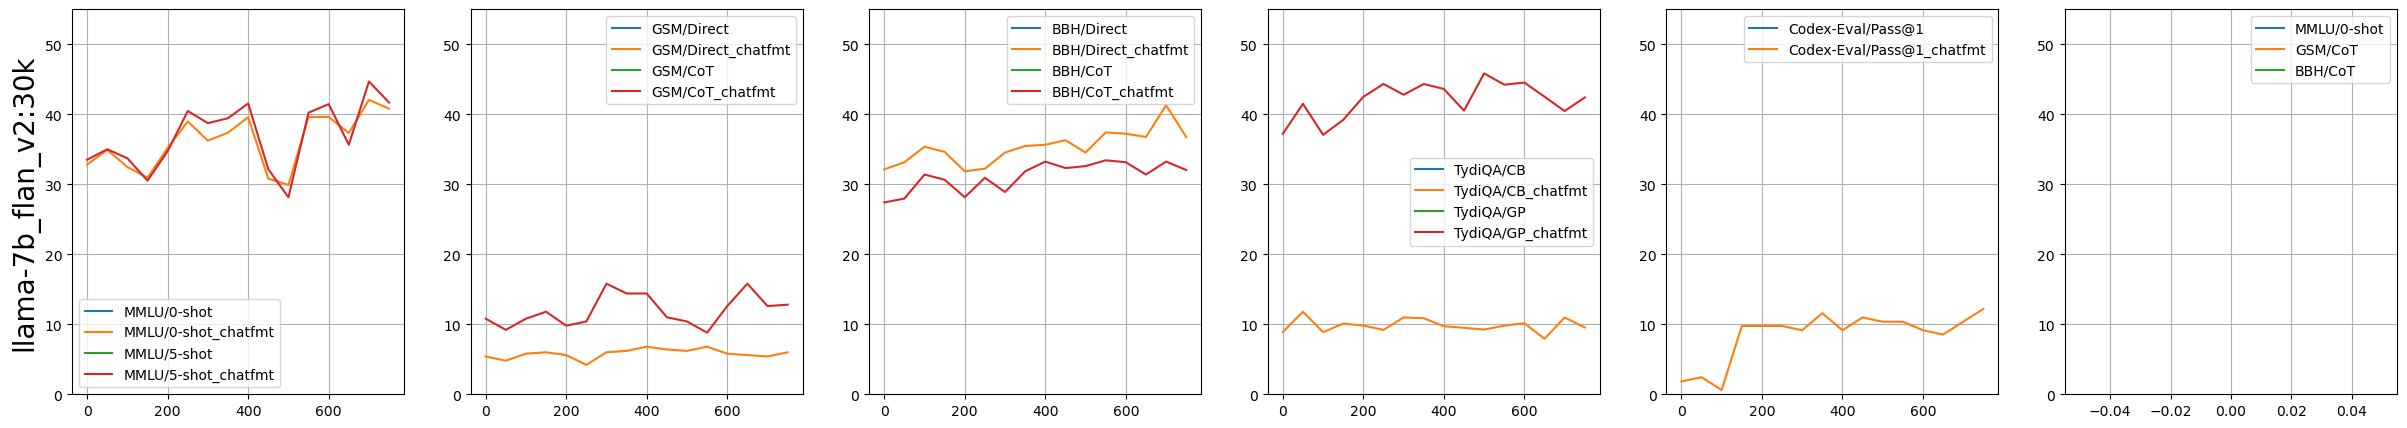

In [26]:
# ylabel = 'llama-7b:600k'
# exp_dir = '../results/oi3'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:600k_humanmix', 'checkpoint-*'))]

ylabel = 'llama-7b_flan_v2:30k'
exp_dir = '../results/oi4_perf_cross_time'
# exp_dir = '../results/oi4_flanv2_prune_with_hmv1_model'
save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in glob.glob(os.path.join(exp_dir, 'llama-7b_flan_v2:30k_kmeansl2_nc=3000_decr', 'checkpoint-*'))]
# save_dirs += [(os.path.basename(x), x) for x in glob.glob(os.path.join(exp_dir, 'llama-7b_flan_v2:30k_kmeansl2_nc=3000_incr', 'checkpoint-*'))]
save_dirs += [(os.path.basename(x), x) for x in glob.glob(os.path.join(exp_dir, 'llama-7b_flan_v2:30k_kmeansl2_nc=3000_incr', 'checkpoint-*'))]
df = get_eval_results(save_dirs, chat_fmt=None, ft_args_fields=ft_args_fields)

dfc = df.copy()

# add base model performance
dfc.loc[dfc['model_args.model_name_or_path']=='huggyllama/llama-7b', 'model_args.model_name_or_path'] = 'checkpoint-0'
# get steps 
dfc.insert(0, 'steps', dfc['model_args.model_name_or_path'].apply(lambda x: int(x.split('-')[-1])))
dfc = dfc.sort_values('steps')


y_labels_list = [
    ['MMLU/0-shot',
     'MMLU/0-shot_chatfmt',
     'MMLU/5-shot',
     'MMLU/5-shot_chatfmt',
    ],
    ['GSM/Direct',
     'GSM/Direct_chatfmt',
     'GSM/CoT', 
     'GSM/CoT_chatfmt', 
    ],
    ['BBH/Direct',
     'BBH/Direct_chatfmt',
     'BBH/CoT',
     'BBH/CoT_chatfmt',
    ],
    ['TydiQA/CB',
     'TydiQA/CB_chatfmt',
     'TydiQA/GP',
     'TydiQA/GP_chatfmt',
    ],
    ['Codex-Eval/Pass@1',
     'Codex-Eval/Pass@1_chatfmt'],
    ['MMLU/0-shot',
     'GSM/CoT',
     'BBH/CoT',],
]

N = len(y_labels_list)

fig, axs = plt.subplots(1,N,figsize=(5*N,5))

axs[0].set_ylabel(ylabel, fontsize=20)

for axi, y_labels in enumerate(y_labels_list):
    ax = axs[axi]

    x = dfc['steps']
    y_list = []
    for y_label in y_labels:
        if y_label not in dfc.columns: continue
        y = dfc[y_label].to_numpy()
        y_list.append(y)
        ax.plot(x, y, label=y_label)
    
    ax.legend()
    ax.grid()
    ax.set_ylim(0, 55)
    
    
# for y_label in ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1']:
    
#     for chat_fmt in ['', 'chatfmt']:
#         col = '_'.join([y_label, chat_fmt]) if chat_fmt else y_label
#         y = dfc[col].to_numpy()
#         print(f'{col}\t{y.mean():.2f}')

    

In [ ]:
df

In [ ]:
import numpy as np

x_labels = [
    'Answer:\n<|assistant|>\nThe answer is:',
    'Answer:\n<|assistant|>\n',
    '<|assistant|>\nAnswer:',
    '<|assistant|>\nThe answer is:',
]
x_labels = [f'v{i+1}:\n{x}' for i,x in enumerate(x_labels)]

dfc = df.copy()
dfc = df.filter(regex='_v|run')

runs = dfc['run_name'].to_list()[::-1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for axi, task in enumerate(['MMLU/0-shot', 'MMLU/5-shot']):

    ax = axs[axi]
    cols = [f'{task}_v{x}' for x in [1, 2, 3, 4]]
    x = np.arange(len(x_labels))

    width = .25
    multiplier = 0

    for run in runs:
        offset = width*multiplier
        y = dfc[dfc['run_name']==run][cols].to_numpy().squeeze()
        rects = ax.bar(x+offset, y, width, label=run)
        ax.bar_label(rects, padding=3, fmt='{:.2f}')
        multiplier += 1

    ax.set_title(task)
    ax.set_xticks(x+width)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 60)



In [ ]:

total_data_points = 200000 # 10000, 50000, 100000, 200000
subsample_mixture_list = []
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items())
] # humanmix mixture.
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.360595703125, "dolly": 0.0021991729736328125, "flan_v2": 0.63037109375, "oasst1": 0.0016956329345703125}.items())
] # pythia-1.4b humanmix_uniform:200k_doremiv1.json

subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.2254638671875, "dolly": 0.01409149169921875, "flan_v2": 0.1739501953125, "oasst1": 0.59423828125}.items())
] # pythia-1.4b humanmix_uniform:200k_doremiv2.json

subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.08563232421875, "dolly": 0.54296875, "flan_v2": 0.347900390625, "oasst1": 0.0103302001953125}.items())
] # llama-7b_humanmix_uniform:200k_doremiv2.json
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.0316162109375, "dolly": 0.204833984375, "flan_v2": 0.40966796875, "oasst1": 0.40966796875}.items()
        )] # llama-7b_humanmix_uniform:600k_doremiv2.json
subsample_mixture_list

In [ ]:
6323+40966+81933+81933

In [ ]:
# exp_dir = 'results/ft1'

# d = {
#     'bbh_s=0': 'bbh_s=3',
#     'gsm': 'gsm_s=8_cot',
#     'mmlu': 'mmlu_s=0',
#     'tydiqa_cb': 'tydiqa_s=1_cb',
#     'tydiqa_gp': 'tydiqa_s=1_gp',
# }

# d.update({k+'_chatfmt': v+'_chatfmt' for k,v in d.items()})

# for subdir in os.listdir(exp_dir):    
#     for task_name_src, task_name_tgt in d.items():
#         path_src = os.path.join(exp_dir, subdir, 'eval', task_name_src)
#         path_tgt = os.path.join(exp_dir, subdir, 'eval', task_name_tgt)
#         if os.path.isdir(path_src):
# #             os.rename(path_src, path_tgt)
#             print(path_src)
#             print(path_tgt)


In [ ]:

dfc = df.copy()
dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
    lambda d: sum(list(d.values())) if d else 200000))
# dfc[dfc['total_train_samples'].apply(
#     lambda x: total_train_samples-500<x<total_train_samples+500)]
dfc

In [ ]:


dfc = df.copy()
dfc.columns = [x.split('_')[0] for x in dfc.columns]
def get_dataset(x):
    x = x.split('+')
    if len(x) == 1:
        return ''
    else:
        d = x[1]
        d = d.replace('_', '')
        return d
dfc['Dataset'] = dfc['Model'].apply(get_dataset)
order_list = ['',
 'superni', 'cot', 'flanv2', 'dolly', 'oasst1',
 'selfinstruct', 'unnaturalinstructions', 'stanfordalpaca', 'codealpaca', 'gpt4alpaca',
 'baize', 'sharegpt', 'humanmix', 'h+gptmix']
dfc['order'] = dfc['Dataset'].map({v: i for i, v in enumerate(order_list)})
dfc = dfc.sort_values('order')
dfc = dfc.drop(columns=['order', 'Dataset'])
dfc = dfc.reset_index(drop=True)

display(dfc[dfc['Model'].apply(lambda x: 'llama-7b' in x and ':' not in x)]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))


display(dfc[dfc['Model'].apply(
            lambda x: 'llama-7b' in x and (
                ':' in x or any(c in x for c in ['dolly', 'oasst1', 'cot', 'flan'])
                or 'humanmix' in x
            )
        )]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))

display(dfc[dfc['Model'].apply(lambda x: 'llama2-7b' in x or 'llama-7b'==x)]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))


In [ ]:
{"dataset": "flan_v2", "id": "flan_v2_2", "messages": [{"role": "user", "content": "Tratatul de la Lisabona nu face inutil referire, pentru prima dată în istoria Uniunii Europene, la drepturile persoanelor care aparţin acestor minorităţi şi la valorile proprii acestora.\n\nWhich language is this?\n"}, {"role": "assistant", "content": "Romanian"}]}
{"dataset": "flan_v2", "id": "flan_v2_2", "messages": [{"role": "user", "content": "Tratatul de la Lisabona nu face inutil referire, pentru prima dat\u0103 \u00een istoria Uniunii Europene, la drepturile persoanelor care apar\u0163in acestor minorit\u0103\u0163i \u015fi la valorile proprii acestora.\n\nWhich language is this?\n"}, {"role": "assistant", "content": "Romanian"}]}


In [ ]:
with pd.option_context('display.float_format', '{:0.1f}'.format):
    display(df[['Model']+[x for x in df.columns if 'chatfmt' in x]])

In [ ]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(df[[x for x in df.columns if 'chatfmt' not in x]])


In [ ]:
import glob

models = []
models += ['t5-small', 't5-base', 't5-large', 't5-3b', 't5-11b']
models += ['huggyllama/llama-7b']
save_dirs = [f'../results/baselines/{x}/eval/gsm/' for x in models]

data = []
for model, save_dir in zip(models, save_dirs):
    logfile_path = glob.glob(os.path.join(save_dir, '*.out'))[0]
    out = get_run_statistics(logfile_path)
    with open(os.path.join(save_dir, 'metrics.json'), 'r') as f:
        metrics = json.load(f)
    data.append((model, out['cpu_time']/60/60, out['avg_mem'], out['max_mem'], metrics['exact_match']))
    

import pandas as pd
columns = ['name', 'cpu_time (hr)', 'avg_mem', 'max_mem', 'exact_match']
df = pd.DataFrame(data, columns=columns)
df

In [ ]:


df

